# Analysis for `MOM6-examples` seamount experiment

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import xarray as xr
import numpy as np
import cmocean as cm
from xgcm import Grid


In [3]:
#!pip install xgcm

In [2]:
base = '/Users/claireyung/mom6/MOM6-examples/ocean_only/'
base_folder = base+'seamount/'
list_folders = ['layer','rho','z','sigma','z-ISOMIPinit','z-bigdomain','z-bigdomain_KHTHKH0',\
                'z-ISOMIPtopo','z-ISOMIPtopo-TS','z-ISOMIPtopo-TS-KH0','z-ISOMIPtopo-shelf','z-ISOMIPtopo-shelf_but_no_shelf',\
                'sigma_shelf_zstar-ISOMIPtopo-shelf','sigma-ISOMIPtopo-shelf_but_no_shelf_sigmaspecial','sigma-ISOMIPtopo-shelf',
               'papatest1']

In [3]:
def open_files(i):
    base = base_folder + list_folders[i]+'/'
    prog = xr.open_dataset(base + 'prog.nc')
    ocean_static = xr.open_dataset(base + "ocean_geometry.nc")
    return prog, ocean_static


In [4]:
prog, ocean_static = open_files(0)
grid = Grid(prog,coords={"x":{"center":"xh","outer":"xq"},
                             "y":{"center":"yh","outer":"yq"},
                             "z":{"center":"zl","outer":"zi"}},periodic=False)

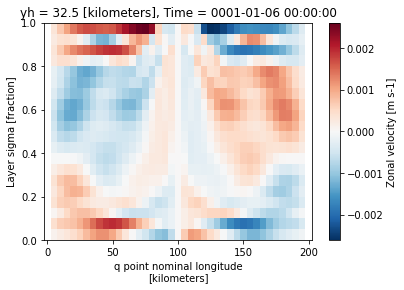

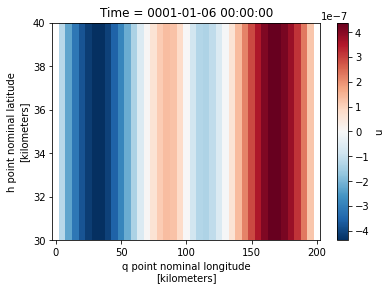

In [5]:
prog, ocean_static = open_files(3)
prog.u.isel(Time = -1).isel(yh = 0).plot()
plt.show()
prog.u.isel(Time = -1).mean('zl').plot()


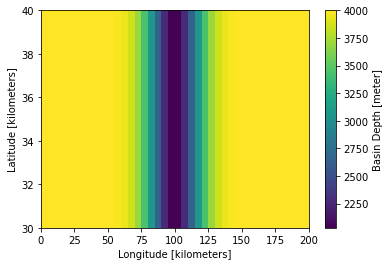

In [34]:
ocean_static.D.plot()

In [35]:
prog

<xarray.Dataset>
Dimensions:  (xq: 41, yh: 2, zl: 20, Time: 720, xh: 40, yq: 3, zi: 21)
Coordinates:
  * xq       (xq) float64 0.0 5.0 10.0 15.0 20.0 ... 185.0 190.0 195.0 200.0
  * yh       (yh) float64 32.5 37.5
  * zl       (zl) float64 0.025 0.075 0.125 0.175 ... 0.825 0.875 0.925 0.975
  * Time     (Time) object 0001-01-01 01:00:00 ... 0001-01-31 00:00:00
  * xh       (xh) float64 2.5 7.5 12.5 17.5 22.5 ... 182.5 187.5 192.5 197.5
  * yq       (yq) float64 30.0 35.0 40.0
  * zi       (zi) float64 0.0 0.05 0.1 0.15 0.2 0.25 ... 0.8 0.85 0.9 0.95 1.0
Data variables:
    u        (Time, zl, yh, xq) float32 ...
    v        (Time, zl, yq, xh) float32 ...
    h        (Time, zl, yh, xh) float64 ...
    e        (Time, zi, yh, xh) float32 ...
    temp     (Time, zl, yh, xh) float32 ...
    salt     (Time, zl, yh, xh) float32 ...
Attributes:
    filename:   prog.nc
    title:      GOLD Experiment
    grid_type:  regular
    grid_tile:  N/A

In [36]:
ocean_static

<xarray.Dataset>
Dimensions:  (lath: 2, lonh: 40, latq: 3, lonq: 41)
Coordinates:
  * lath     (lath) float64 32.5 37.5
  * lonh     (lonh) float64 2.5 7.5 12.5 17.5 22.5 ... 182.5 187.5 192.5 197.5
  * latq     (latq) float64 30.0 35.0 40.0
  * lonq     (lonq) float64 0.0 5.0 10.0 15.0 20.0 ... 185.0 190.0 195.0 200.0
Data variables: (12/19)
    geolatb  (latq, lonq) float64 ...
    geolonb  (latq, lonq) float64 ...
    geolat   (lath, lonh) float64 ...
    geolon   (lath, lonh) float64 ...
    D        (lath, lonh) float64 ...
    f        (latq, lonq) float64 ...
    ...       ...
    dyBu     (latq, lonq) float64 ...
    Ah       (lath, lonh) float64 ...
    Aq       (latq, lonq) float64 ...
    dxCvo    (latq, lonh) float64 ...
    dyCuo    (lath, lonq) float64 ...
    wet      (lath, lonh) float64 ...
Attributes:
    filename:  ./ocean_geometry.nc

In [6]:
## plot a transect of variable with given y section (yy0) and time (tt)
def plot(ax,yy0,tt,i,variable,varname,vmin1,vmax1,cmap,ymax = 720):
    prog, ocean_static = open_files(i)
    grid = Grid(prog,coords={"x":{"center":"xh","outer":"xq"},
                             "y":{"center":"yh","outer":"yq"},
                             "z":{"center":"zl","outer":"zi"}},periodic=False)
    file_name = list_folders[i]
    label = list_folders[i]
    depth = grid.interp(prog.e,'x')
    lon = ocean_static.geolonb
    dataplot = variable

    xx = lon
    if varname == "uo": dataplot = dataplot[:,:,:,:-1]
    levels = np.linspace(vmin1, vmax1, 51)
    yy = depth[:,:,yy0,:]
    z_levels = yy.shape[1]
    yi = np.linspace(0,5000,z_levels) #Dummy, just for have z_levels
    # plot variable in colours
    xi, yyi = np.meshgrid(xx[yy0,:], yi) #We repeat the horizontal part of the grid by the number of zlevels
    #cax = ax.contourf(xi,yy[tt,...],dataplot[tt,:,yy0,:],levels = levels, cmap = cmap, extend = 'both',corner_mask = False)
    #print(xi.shape)
    #print(yy[tt,...].shape)
    #print(dataplot[tt,:,yy0,:].shape)
    cax = ax.pcolormesh(xi,yy[tt,...],dataplot[tt,:,yy0,:],vmin = vmin1, vmax = vmax1, cmap = cmap)
    
    plt.colorbar(cax, ax = ax, label = varname)
    
    ## plot interface heights
    i_heights = prog.e # this is 'Interface Height Relative to Mean Sea Level'
    # do for one time
    i_heights = i_heights.isel(Time = tt)
    # take zonal mean
    i_heights = i_heights.isel(yh = yy0)#.mean('xh')

    # plot a line of layer depths, layer by layer
    nz = len(i_heights.zi)
    xh = prog.xh

    for i in range(nz):
        ax.plot(xh,i_heights[i], color = 'k', linewidth = 0.5)
    
    ax.set_ylim(ymin=-ymax,ymax=0)
    ax.set_ylabel('Depth (m)')
    ax.set_xlabel('x (km)')
    ax.set_title(varname+' , ' +label)
    
# find horizontal speed
def find_speed(prog):
    # interpolate speeds to the same grid
    uo_interp = grid.interp(prog.u,'x',boundary='extend')
    #vo_interp = grid.interp(prog.v,'y',boundary='extend')
    horiz_speed = np.sqrt(uo_interp**2)#+vo_interp**2)
    return horiz_speed

time = 0001-01-06 00:00:00


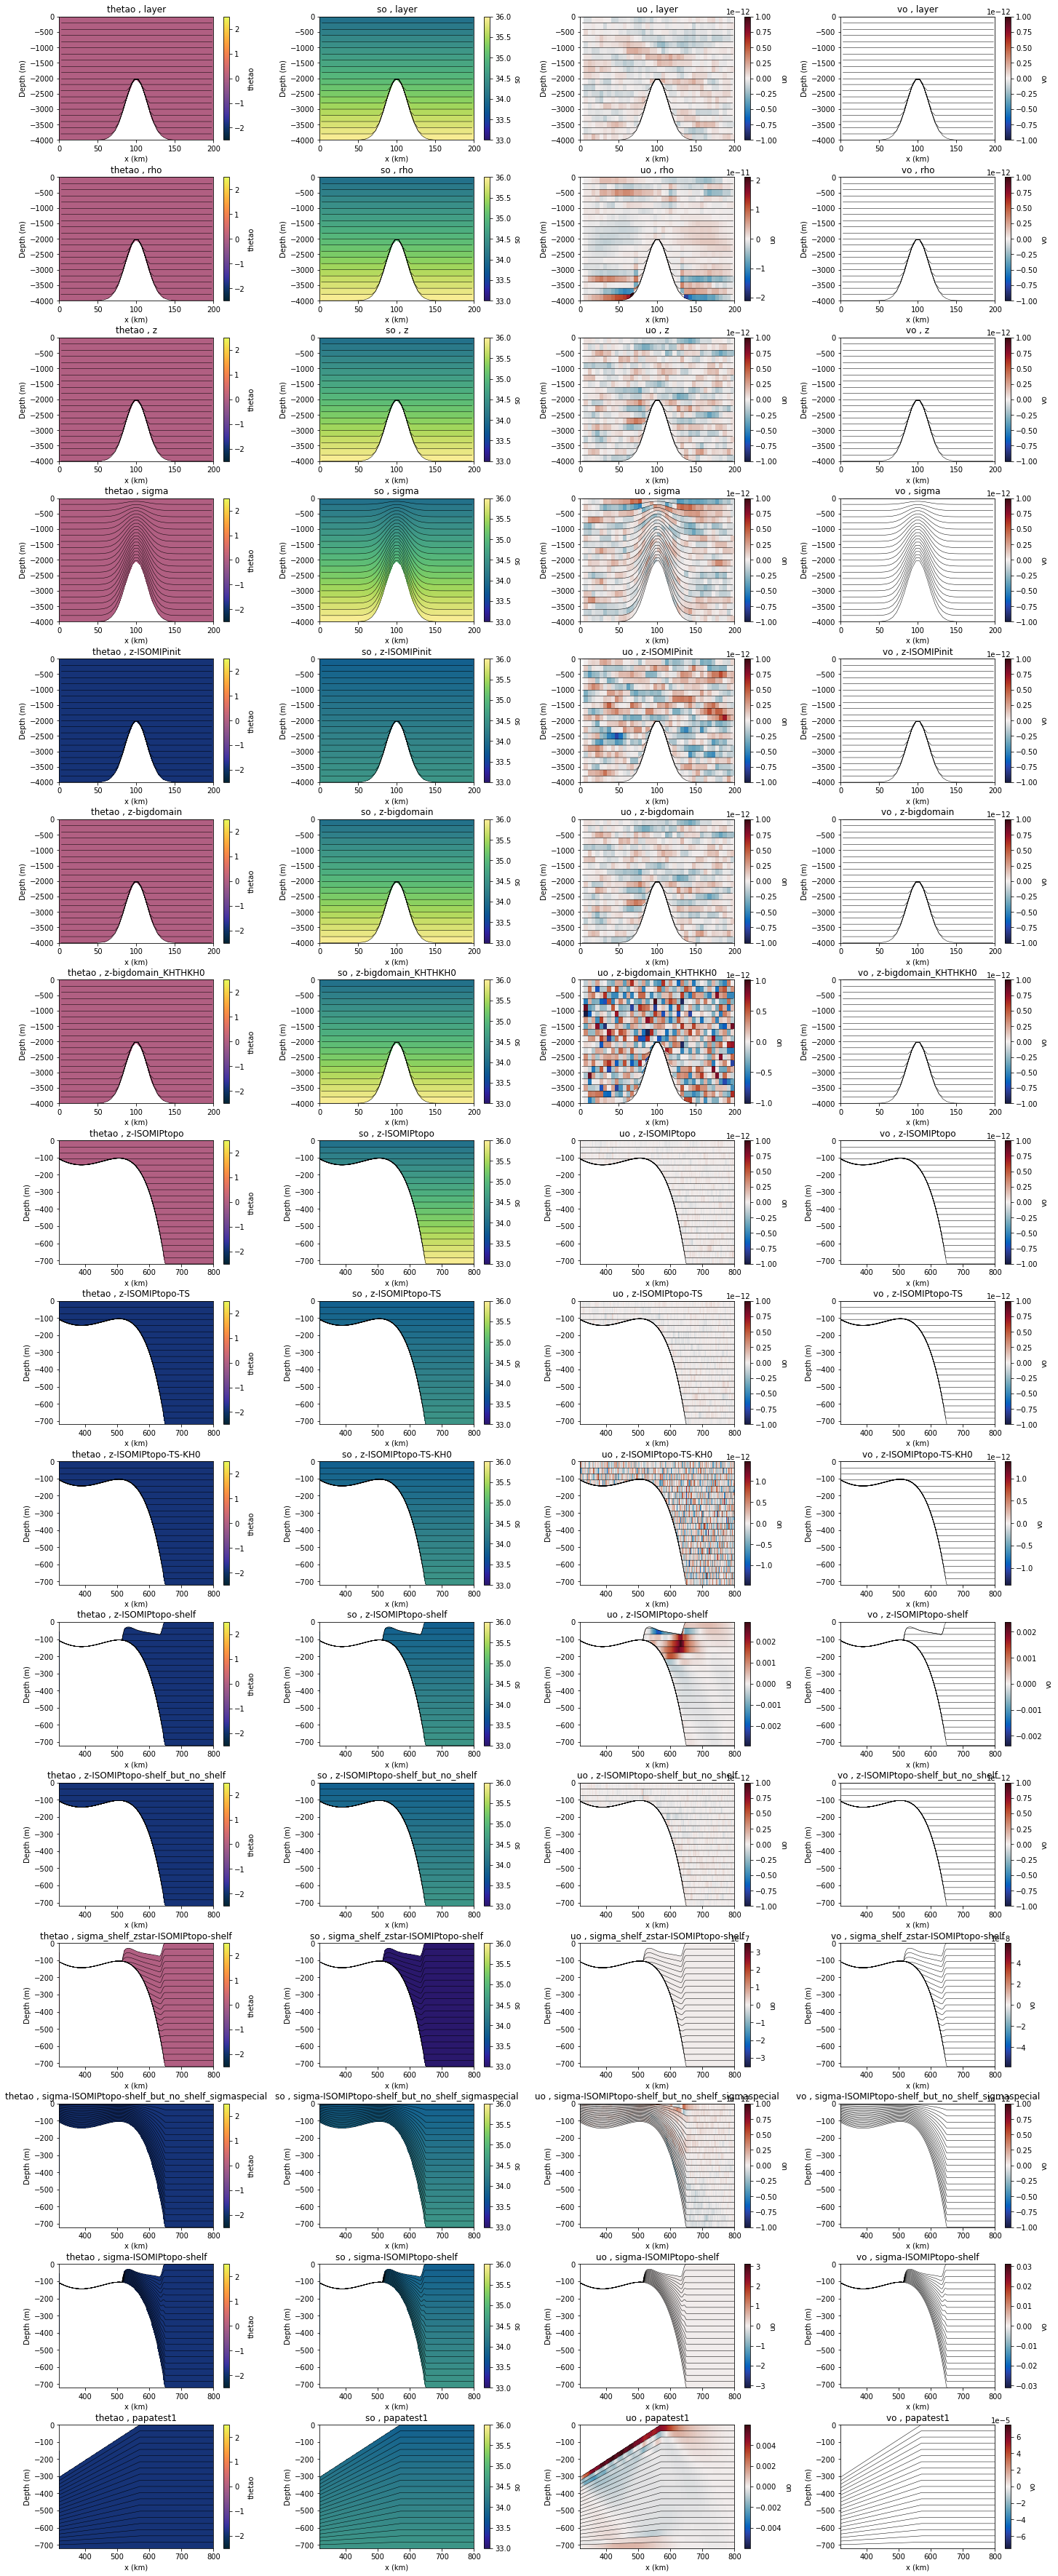

In [38]:
no_configs = len(list_folders)
fig,axes = plt.subplots(nrows = no_configs, ncols = 4, figsize = (24,4*no_configs))
time = 24*5-1 ## 5 days
x = 0
ymax = 4000
for j in np.arange(no_configs):
    if j >= 7:
        ymax = 720
    prog, ocean_static = open_files(j)
    #plot temp
    plot(axes[j,0],x,time,j,prog.temp,"thetao",-2.5,2.5,cm.cm.thermal,ymax)
    # plot salinity
    plot(axes[j,1],x,time,j,prog.salt,"so",33,36,cm.cm.haline,ymax)
    # plot u
    scale = np.abs(prog.isel(Time = time).u).max().values
    if scale < 1e-12: ## in case of very small number
        scale = 1e-12
    scale = scale#/10
    plot(axes[j,2],x,time,j,prog.u,"uo",-scale,scale,cm.cm.balance,ymax)
    # plot v
    scale = np.abs(prog.isel(Time = time).v).max().values
    if scale < 1e-12: ## in case of very small number
        scale = 1e-12
    scale = scale#/10
    plot(axes[j,3],x,time,j,prog.v,"vo",-scale,scale,cm.cm.balance,ymax)

plt.subplots_adjust(wspace = 0.35, hspace = 0.3)

print('time = '+str(prog.isel(Time = time).Time.values))

time = 0001-01-06 00:00:00


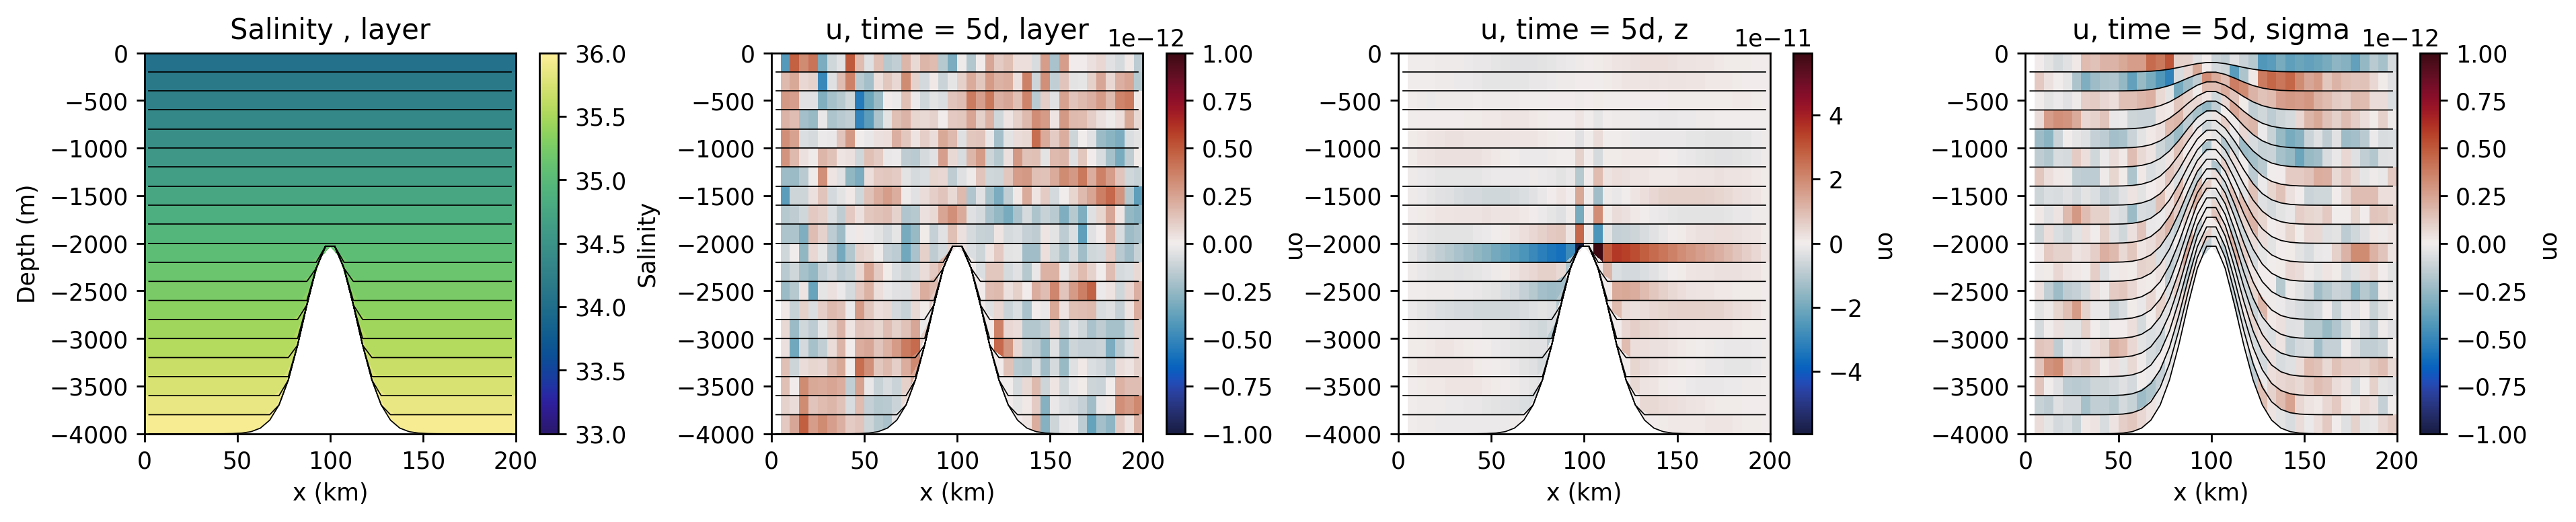

In [27]:
base = '/Users/claireyung/mom6/MOM6-examples/ocean_only/'
base_folder = base+'seamount/'
list_folders = ['layer','z','sigma']
                
no_configs = len(list_folders)
fig,axes = plt.subplots(ncols = 4, figsize = (18,3),dpi = 250)
time = 24*5-1 ## 5 days
x = 0
ymax = 4000
for j in np.arange(3):
    if j >= 7:
        ymax = 720
    prog, ocean_static = open_files(j)
    #plot temp
    if j == 0:
        plot(axes[0],x,time,j,prog.salt,"Salinity",33,36,cm.cm.haline,ymax)
    # plot u
    scale = np.abs(prog.isel(Time = time).u).max().values
    if scale < 1e-12: ## in case of very small number
        scale = 1e-12
    scale = scale#/10
    plot(axes[j+1],x,time,j,prog.u,"uo",-scale,scale,cm.cm.balance,ymax)

plt.subplots_adjust(wspace = 0.35, hspace = 0.3)
axes[1].set_ylabel('')
axes[2].set_ylabel('')
axes[3].set_ylabel('')

axes[1].set_title('u, time = 5d, layer')
axes[2].set_title('u, time = 5d, z')
axes[3].set_title('u, time = 5d, sigma')

print('time = '+str(prog.isel(Time = time).Time.values))

time = 0001-01-31 00:00:00


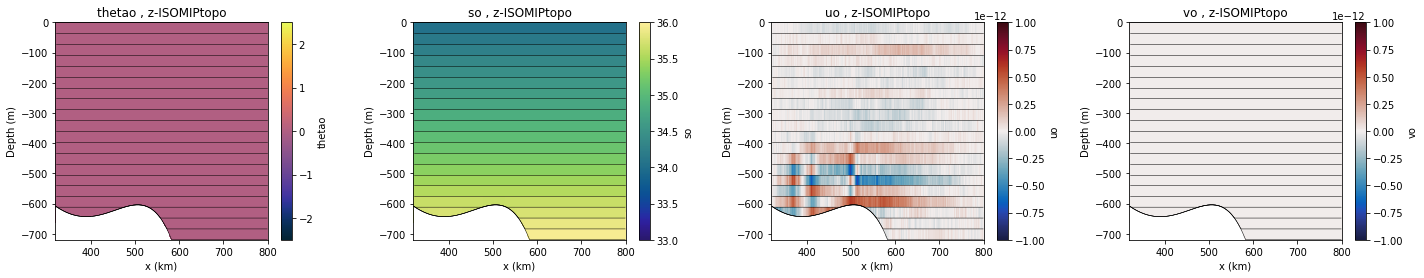

In [13]:
no_configs = len(list_folders)
fig,axes = plt.subplots(nrows = 1, ncols = 4, figsize = (24,4))
time = -1 ## 5 days
x = 20
for j in np.array([7]):
    prog, ocean_static = open_files(j)
    #plot temp
    plot(axes[0],x,time,j,prog.temp,"thetao",-2.5,2.5,cm.cm.thermal,720)
    # plot salinity
    plot(axes[1],x,time,j,prog.salt,"so",33,36,cm.cm.haline,720)
    # plot u
    scale = np.abs(prog.isel(Time = time).u).max().values
    if scale < 1e-12: ## in case of very small number
        scale = 1e-12
    scale = scale#/10
    plot(axes[2],x,time,j,prog.u,"uo",-scale,scale,cm.cm.balance,720)
    # plot v
    scale = np.abs(prog.isel(Time = time).v).max().values
    if scale < 1e-12: ## in case of very small number
        scale = 1e-12
    scale = scale#/10
    plot(axes[3],x,time,j,prog.v,"vo",-scale,scale,cm.cm.balance,720)

plt.subplots_adjust(wspace = 0.35, hspace = 0.3)

print('time = '+str(prog.isel(Time = time).Time.values))

Velocities are MUCH smaller than ISOMIP with same salinity stratification. DOmain size? Layer thickness?? Doesn't seem to be ISOMIP thickness or TS initialization.

- Also fixed code to use pcolormesh so now all of ocean is coloured (before had missing bottom layer)

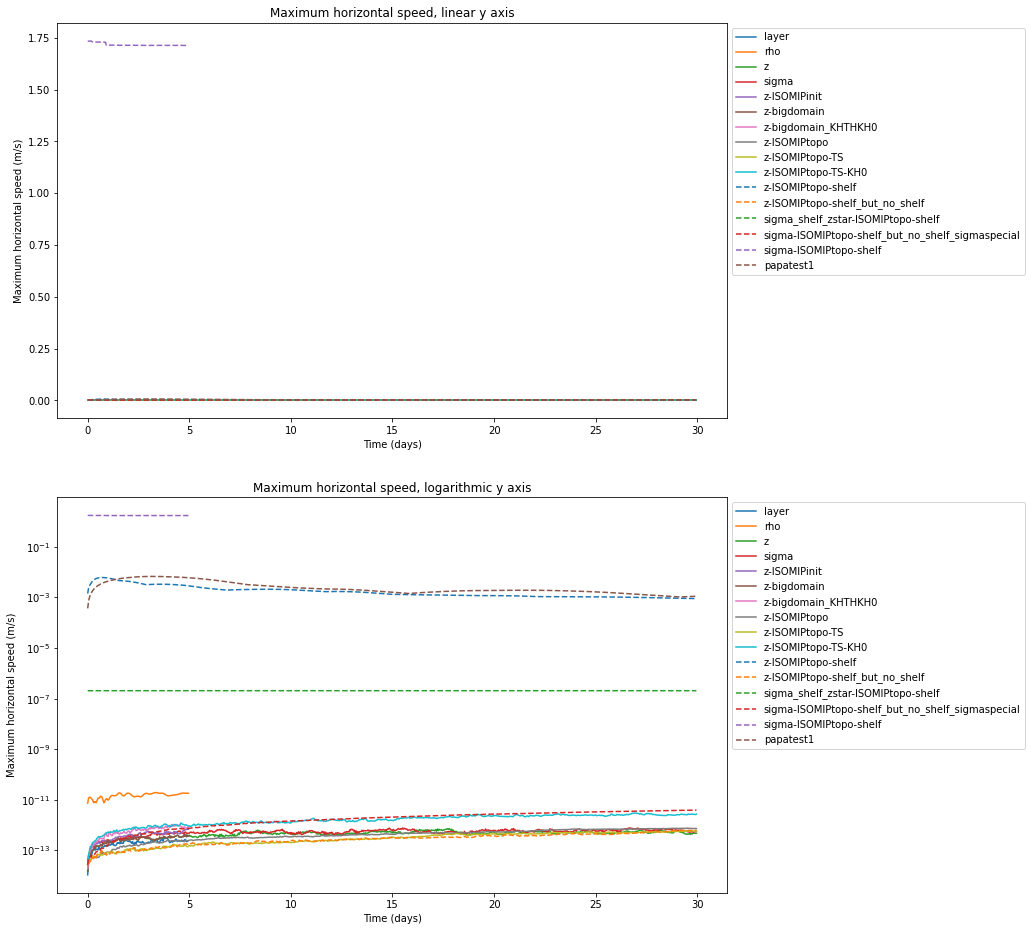

In [39]:
fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (12,16))
linestyle = '-'
for j in np.arange(no_configs):
    prog, ocean_static = open_files(j)
    label = list_folders[j]
    # Generate xgcm grid object:
    grid = Grid(prog,coords={"x":{"center":"xh","outer":"xq"},
                                 "y":{"center":"yh","outer":"yq"},
                                 "z":{"center":"zl","outer":"zi"}},periodic=False)
    if j >= 10:
        linestyle = '--'
    horiz_speed = find_speed(prog)
    Time = (np.arange(len(prog.Time)))/24
    axes[0].plot(Time,horiz_speed.max(['zl','xh','yh']),label = label, linestyle = linestyle)
    axes[1].plot(Time,horiz_speed.max(['zl','xh','yh']),label = label, linestyle = linestyle)
    #axes[2].plot(Time,horiz_speed.max(['zl','xh','yh']),label = label, linestyle = linestyle)

        
axes[0].set_ylabel('Maximum horizontal speed (m/s)')
axes[0].set_xlabel('Time (days)')
axes[0].legend(bbox_to_anchor = (1,1),loc = 'upper left')
axes[0].set_title('Maximum horizontal speed, linear y axis')

axes[1].set_yscale('log')
axes[1].set_ylabel('Maximum horizontal speed (m/s)')
axes[1].set_xlabel('Time (days)')
axes[1].legend(bbox_to_anchor = (1,1),loc = 'upper left')
axes[1].set_title('Maximum horizontal speed, logarithmic y axis')

# axes[2].set_yscale('log')
# axes[2].set_ylabel('Maximum horizontal speed (m/s)')
# axes[2].set_xlabel('Time (days)')
# axes[2].legend(bbox_to_anchor = (1,1),loc = 'upper left')
# axes[2].set_title('Maximum horizontal speed, logarithmic y axis')
# axes[2].set_ylim(1e-3,1e-1)

plt.show()


In [18]:
base = '/Users/claireyung/mom6/MOM6-examples/ocean_only/'
base_folder = base+'seamount/'
list_folders = ['layer','rho','z','sigma','z-ISOMIPinit','z-bigdomain','z-bigdomain_KHTHKH0',\
                'z-ISOMIPtopo','z-ISOMIPtopo-TS','z-ISOMIPtopo-TS-KH0','z-ISOMIPtopo-shelf','z-ISOMIPtopo-shelf_but_no_shelf',\
                'sigma_shelf_zstar-ISOMIPtopo-shelf','sigma-ISOMIPtopo-shelf_but_no_shelf_sigmaspecial','sigma-ISOMIPtopo-shelf',\
                'sigma-ISOMIPtopo-shelf_but_no_shelf_testing']

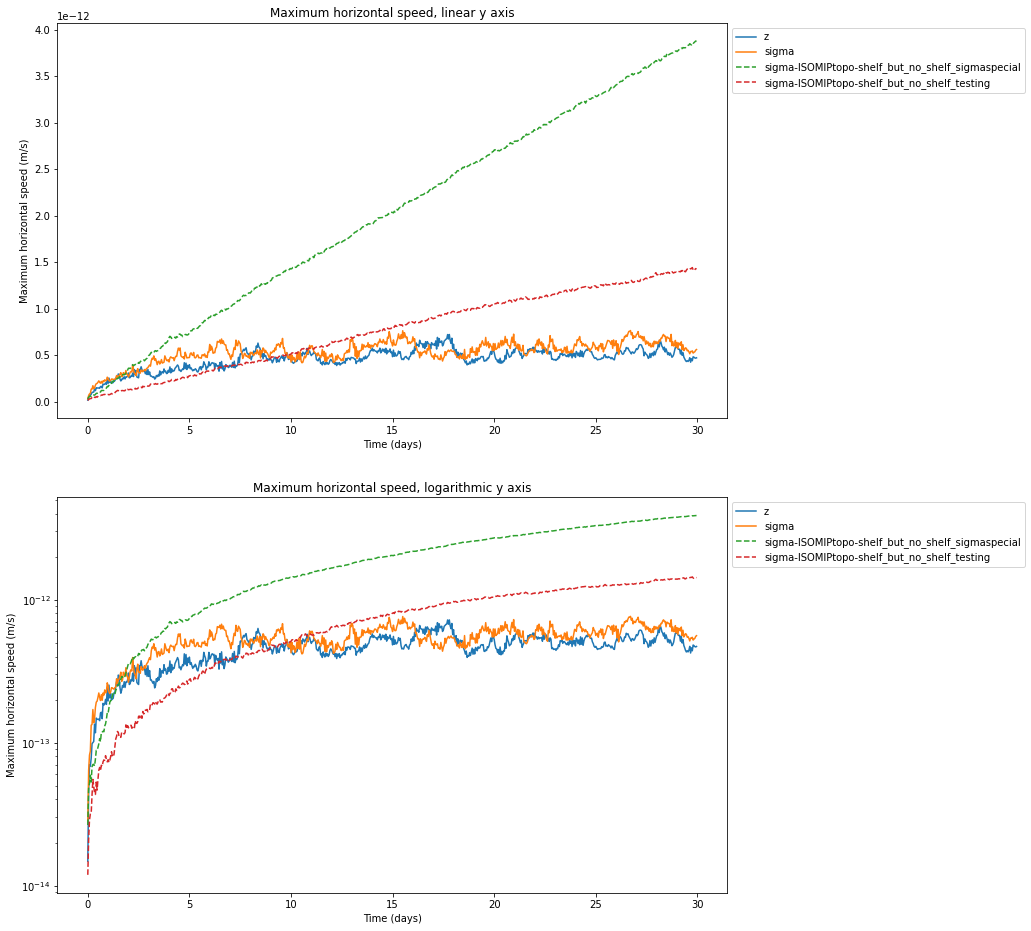

In [19]:
fig, axes = plt.subplots(nrows = 2, ncols = 1, figsize = (12,16))
linestyle = '-'
for j in np.array([2,3,13,15]):
    prog, ocean_static = open_files(j)
    label = list_folders[j]
    # Generate xgcm grid object:
    grid = Grid(prog,coords={"x":{"center":"xh","outer":"xq"},
                                 "y":{"center":"yh","outer":"yq"},
                                 "z":{"center":"zl","outer":"zi"}},periodic=False)
    if j >= 10:
        linestyle = '--'
    horiz_speed = find_speed(prog)
    Time = (np.arange(len(prog.Time)))/24
    axes[0].plot(Time,horiz_speed.max(['zl','xh','yh']),label = label, linestyle = linestyle)
    axes[1].plot(Time,horiz_speed.max(['zl','xh','yh']),label = label, linestyle = linestyle)
    #axes[2].plot(Time,horiz_speed.max(['zl','xh','yh']),label = label, linestyle = linestyle)

        
axes[0].set_ylabel('Maximum horizontal speed (m/s)')
axes[0].set_xlabel('Time (days)')
axes[0].legend(bbox_to_anchor = (1,1),loc = 'upper left')
axes[0].set_title('Maximum horizontal speed, linear y axis')

axes[1].set_yscale('log')
axes[1].set_ylabel('Maximum horizontal speed (m/s)')
axes[1].set_xlabel('Time (days)')
axes[1].legend(bbox_to_anchor = (1,1),loc = 'upper left')
axes[1].set_title('Maximum horizontal speed, logarithmic y axis')

# axes[2].set_yscale('log')
# axes[2].set_ylabel('Maximum horizontal speed (m/s)')
# axes[2].set_xlabel('Time (days)')
# axes[2].legend(bbox_to_anchor = (1,1),loc = 'upper left')
# axes[2].set_title('Maximum horizontal speed, logarithmic y axis')
# axes[2].set_ylim(1e-3,1e-1)

plt.show()
